# Balancing Data

Dataset yang tidak seimbang dapat menimbulkan bias pada model machine learning, di mana model lebih condong mengenali kelas mayoritas dan mengabaikan kelas minoritas. Untuk mengatasi hal ini, digunakan metode ADASYN (Adaptive Synthetic Sampling) yang secara adaptif menghasilkan data sintetis baru pada kelas minoritas, khususnya di area yang sulit dipelajari model.

Notebook ini bertujuan menunjukkan bagaimana [**Data ecoli**](https://archive.ics.uci.edu/dataset/39/ecoli) yang awalnya tidak seimbang dapat diseimbangkan dengan ADASYN, serta membandingkan distribusi data sebelum dan sesudah balancing melalui scatter plot. Dengan proses ini, model diharapkan mampu memberikan prediksi yang lebih adil dan akurat pada semua kelas.

## Import Library Pendukung

In [1]:
!pip install pymysql python-dotenv imbalanced-learn pandas matplotlib seaborn

In [2]:
import pymysql
from dotenv import load_dotenv
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import ADASYN

ModuleNotFoundError: No module named 'dotenv'

## Koneksi MySQL dan Ambil Data

Data ecoli yang digunakan telah diimport ke DMBS MySQL, oleh karena itu perlu untuk mengkoneksikan file ipynb ini dengan DBMS MySQL. Code di bawah menunjukkan cara untuk koneksi database menggunakan modul pymysql yang sudah diinstall di tahap awal. Demi keamanan, penulis menggunakan environment variabel untuk membinding kredensial database yang digunakan.

In [57]:
load_dotenv()

host = os.getenv("DB_HOST")
port = os.getenv("DB_PORT")
user = os.getenv("DB_USER")
password = os.getenv("DB_PASS")
db = os.getenv("DB_NAME")

conn = pymysql.connect(
  host = host,
  port = int(port),
  user = user,
  password = password,
  database = db,
)

query = "SELECT * FROM ecoli.data_ecoli"

df = pd.read_sql(query, conn)
conn.close()

C:\Users\Muhammad Junaidi\AppData\Local\Temp\ipykernel_6104\339049370.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


## Over Sampling Menggunakan ADASYN

Kode di bawah berfungsi untuk balencing data menggunakan teknik over sampling ADASYN

In [58]:
X = df.drop(['class', 'sequence_name', 'id'], axis=1)
y = df['class']

# Jumlah data asli
n_original = len(X)

X_res_adasyn = X
y_res_adasyn = y

class_counts = df['class'].value_counts().to_dict().values()
sorted_class_count = sorted(class_counts)

for i in range(0, 7):
    n = sorted_class_count[i] - 1
    X_res_adasyn, y_res_adasyn = ADASYN(n_neighbors=n, sampling_strategy='minority').fit_resample(X_res_adasyn, y_res_adasyn)


# Dataframe hasil balancing
df_res_adasyn = pd.DataFrame(X_res_adasyn, columns=X_res_adasyn.columns)
df_res_adasyn['class'] = y_res_adasyn

# Menandai mana data asli dan mana hasil generate
df_res_adasyn['status'] = ['original'] * n_original + ['synthetic'] * (len(X_res_adasyn) - n_original)

### Distribusi Kelas
Kode di bawah ini berfungsi untuk melihat distribusi kelas sebelum dan sesudah menerapkan ADASYN


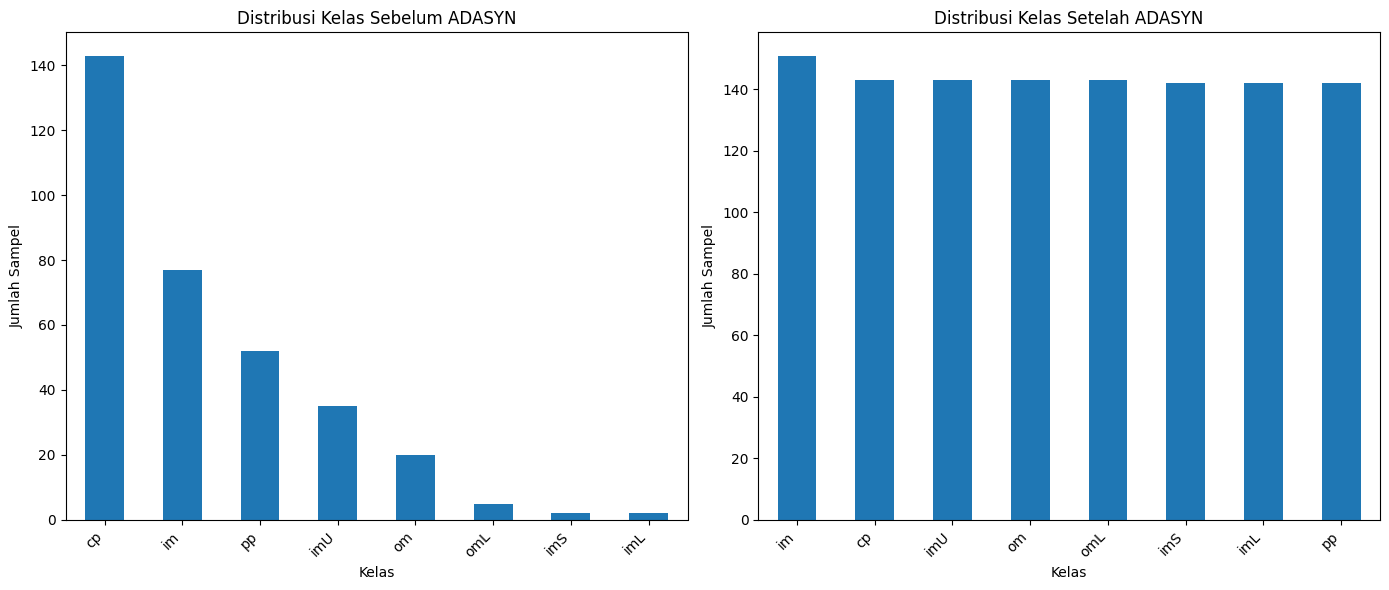

Distribusi kelas sebelum balancing menggunakan ADASYN:
class
cp     143
im      77
pp      52
imU     35
om      20
omL      5
imS      2
imL      2
Name: count, dtype: int64

Distribusi kelas sesudah balancing menggunakan ADASYN:
class
im     151
cp     143
imU    143
om     143
omL    143
imS    142
imL    142
pp     142
Name: count, dtype: int64


In [59]:
# Visualisasi distribusi kelas sebelum balancing
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
df['class'].value_counts().plot(kind='bar')
plt.title('Distribusi Kelas Sebelum ADASYN')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Sampel')
plt.xticks(rotation=45, ha='right')

# Visualisasi distribusi kelas setelah balancing
plt.subplot(1, 2, 2)
df_res_adasyn['class'].value_counts().plot(kind='bar')
plt.title('Distribusi Kelas Setelah ADASYN')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Sampel')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("Distribusi kelas sebelum balancing menggunakan ADASYN:")
print(df['class'].value_counts())

print("\nDistribusi kelas sesudah balancing menggunakan ADASYN:")
print(df_res_adasyn['class'].value_counts())

### Plotting Scatter

Plotting ini bertujuan untuk membuat visualisasi perbandingkan sebelum dan sesudah data balencing menggunakan ADASYN.

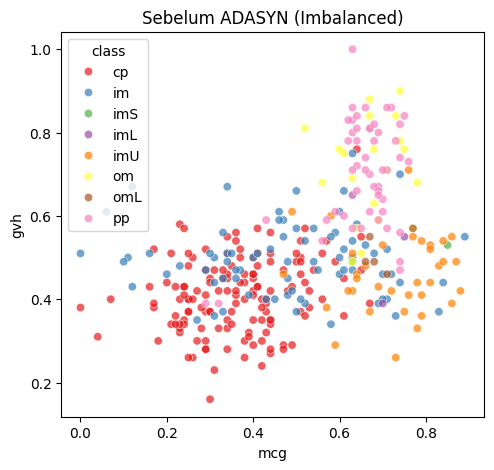

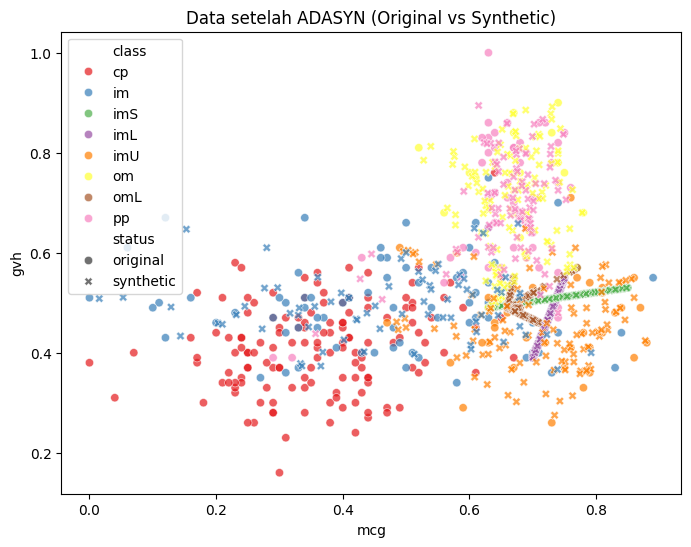

In [60]:
# Plot sebelum balancing
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(x='mcg', y='gvh', hue=y, data=df, palette='Set1', alpha=0.7)
plt.title("Sebelum ADASYN (Imbalanced)")

plt.figure(figsize=(8,6))
sns.scatterplot(x='mcg', y='gvh', hue='class', style='status',
                data=df_res_adasyn, palette='Set1', alpha=0.7)
plt.title("Data setelah ADASYN (Original vs Synthetic)")
plt.show()

Pada visualisasi data scatter plot sesudah menerapkan ADASYN, data original ditandai sebagai tanda dot atau lingkaran sedangkan data sintetis atau hasil generate ditandai dengan simbol silang atau x.

## Over Sampling Menggunakan SMOTE

Kode di bawah berfungsi untuk balencing data menggunakan teknik over sampling SMOTE (Synthetic Minority Over-sampling Technique). SMOTE bekerja dengan menghasilkan sampel sintetis baru di antara sampel minoritas yang sudah ada.

In [61]:
from imblearn.over_sampling import SMOTE

# Terapkan SMOTE
# n_neighbors otomatis (harus < min_class_count)
min_class_count = df['class'].value_counts().min()
n_neighbors = min(1, min_class_count - 1)

smote = SMOTE(random_state=42, k_neighbors=n_neighbors)
X_res_smote, y_res_smote = smote.fit_resample(X, y)

# Dataframe hasil balancing dengan SMOTE
df_res_smote = pd.DataFrame(X_res_smote, columns=X_res_smote.columns)
df_res_smote['class'] = y_res_smote

### Distribusi Kelas
Kode di bawah ini berfungsi untuk melihat distribusi kelas sebelum dan sesudah menerapkan SMOTE


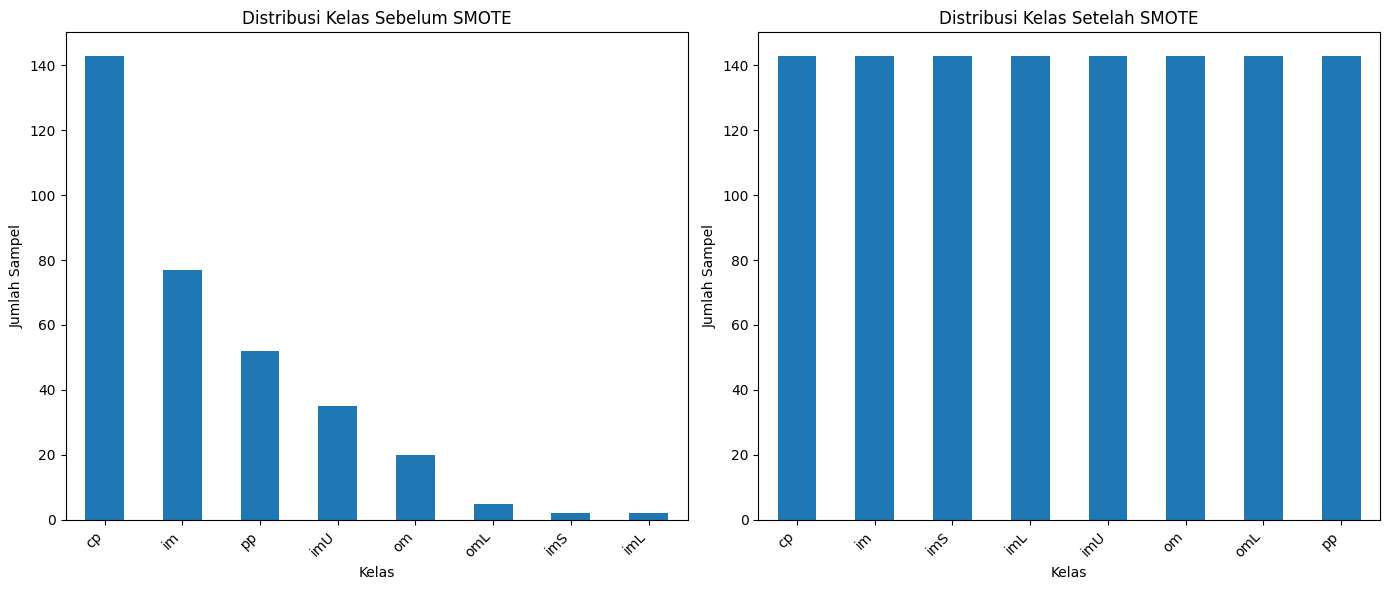

Distribusi kelas sebelum balancing menggunakan SMOTE:
class
cp     143
im      77
pp      52
imU     35
om      20
omL      5
imS      2
imL      2
Name: count, dtype: int64

Distribusi kelas sesudah balancing menggunakan SMOTE:
class
cp     143
im     143
imS    143
imL    143
imU    143
om     143
omL    143
pp     143
Name: count, dtype: int64


In [62]:
# Visualisasi distribusi kelas sebelum dan sesudah balancing dengan SMOTE
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
df['class'].value_counts().plot(kind='bar')
plt.title('Distribusi Kelas Sebelum SMOTE')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Sampel')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
df_res_smote['class'].value_counts().plot(kind='bar')
plt.title('Distribusi Kelas Setelah SMOTE')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Sampel')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("Distribusi kelas sebelum balancing menggunakan SMOTE:")
print(df['class'].value_counts())

print("\nDistribusi kelas sesudah balancing menggunakan SMOTE:")
print(df_res_smote['class'].value_counts())

### Plotting Scatter

Plot scatter ini membandingkan visualisasi data sebelum dan sesudah balancing menggunakan SMOTE. Data asli ditandai dengan lingkaran, sedangkan data sintetis hasil SMOTE ditandai dengan simbol silang.

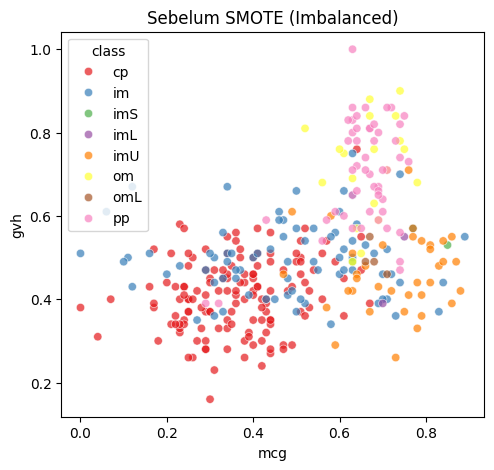

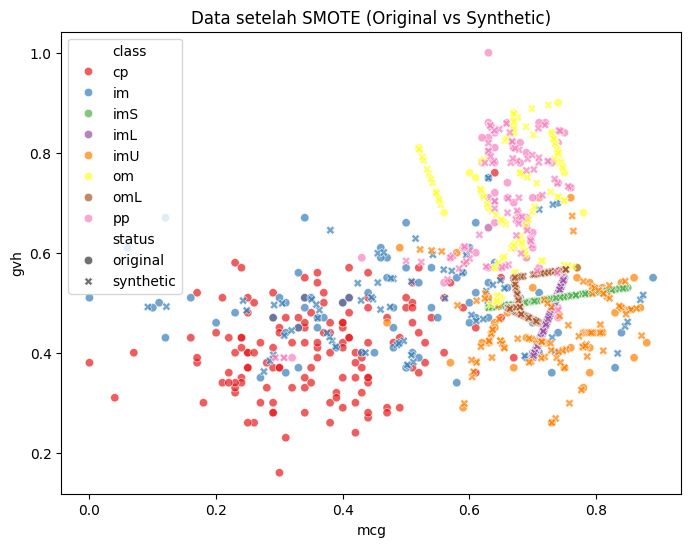

In [63]:
# Jumlah data asli
n_original = len(X)

# Menandai mana data asli dan mana hasil generate oleh SMOTE
df_res_smote['status'] = ['original'] * n_original + ['synthetic'] * (len(X_res_smote) - n_original)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(x='mcg', y='gvh', hue=y, data=df, palette='Set1', alpha=0.7)
plt.title("Sebelum SMOTE (Imbalanced)")

plt.figure(figsize=(8,6))
sns.scatterplot(x='mcg', y='gvh', hue='class', style='status',
                data=df_res_smote, palette='Set1', alpha=0.7)
plt.title("Data setelah SMOTE (Original vs Synthetic)")
plt.show()